# NPZ vs EEGLAB (.set/.fdt) Data Exploration

This notebook helps compare a processed per-run `.npz` output to the original EEGLAB `.set/.fdt` run.

Key features:
- Resolves paths from the project root (not from notebook location)
- Loads config `eeg_analysis/configs/secondary_processing.yaml` to find source root
- Lists available per-run `.npz` files saved per subject
- Loads the matching `.set` file, resamples to 256 Hz, aligns channels, and compares waveforms
- Computes amplitude stats and correlations; provides quick plots


In [10]:
import os
import sys
import json
import subprocess
from pathlib import Path
import yaml
import numpy as np
import matplotlib.pyplot as plt
import mne

# Make sure the repo root is detected reliably

def get_project_root() -> Path:
    # 1) Env override
    env = os.environ.get("PROJECT_ROOT")
    if env and Path(env).exists():
        return Path(env).resolve()
    # 2) git root
    try:
        out = subprocess.check_output(["git", "rev-parse", "--show-toplevel"], cwd=os.getcwd())
        return Path(out.decode().strip())
    except Exception:
        pass
    # 3) climb up until we find 'eeg_analysis'
    p = Path.cwd()
    for _ in range(6):
        if (p / "eeg_analysis").exists():
            return p
        p = p.parent
    return Path.cwd()

PROJECT_ROOT = get_project_root()
print("Project root:", PROJECT_ROOT)

# Paths from project root (never relative to this notebook)
CONFIG_PATH = PROJECT_ROOT / "eeg_analysis" / "configs" / "secondary_processing.yaml"
OUTPUT_BASE = (PROJECT_ROOT / "eeg_analysis" / "secondarydata" / "raw")

print("Config path:", CONFIG_PATH)
print("Per-run NPZ base:", OUTPUT_BASE)

assert CONFIG_PATH.exists(), f"Missing config: {CONFIG_PATH}"



Project root: /home/abin/eeg-mlflow
Config path: /home/abin/eeg-mlflow/eeg_analysis/configs/secondary_processing.yaml
Per-run NPZ base: /home/abin/eeg-mlflow/eeg_analysis/secondarydata/raw


In [11]:
# Load config to find source_root for EEGLAB files
with open(CONFIG_PATH, "r") as f:
    cfg = yaml.safe_load(f)

SOURCE_ROOT = Path(cfg["paths"]["source_root"]).resolve()
TARGET_SFREQ = int(cfg["processing"]["target_sampling_rate"])  # 256
print("Source root:", SOURCE_ROOT)
print("Target sfreq:", TARGET_SFREQ)

assert SOURCE_ROOT.exists(), f"Missing source_root: {SOURCE_ROOT}"



Source root: /home/abin/ds003478-download
Target sfreq: 256


In [13]:
# Utilities for listing and selecting runs
from typing import List, Tuple, Dict

def list_npz_runs(base: Path) -> List[Path]:
    return sorted(base.rglob("*.npz"))

npz_files = list_npz_runs(OUTPUT_BASE)
print(f"Found {len(npz_files)} per-run npz files under {OUTPUT_BASE}")
for p in npz_files[:8]:
    print(" -", p.relative_to(PROJECT_ROOT))

# Choose a subject and run (edit these two if needed)
# Example: 'sub-014', 'sub-014_task-Rest_run-01_eeg'
SUBJECT_ID = None  # if None, take from first npz path
RUN_STEM = None   # if None, take from the npz filename stem

if npz_files:
    first = npz_files[0]
    if SUBJECT_ID is None:
        SUBJECT_ID = first.parent.name
    if RUN_STEM is None:
        RUN_STEM = first.stem

print("Subject:", SUBJECT_ID)
print("Run stem:", RUN_STEM)



Found 243 per-run npz files under /home/abin/eeg-mlflow/eeg_analysis/secondarydata/raw
 - eeg_analysis/secondarydata/raw/sub-001/sub-001_task-Rest_run-01_eeg.npz
 - eeg_analysis/secondarydata/raw/sub-001/sub-001_task-Rest_run-02_eeg.npz
 - eeg_analysis/secondarydata/raw/sub-002/sub-002_task-Rest_run-01_eeg.npz
 - eeg_analysis/secondarydata/raw/sub-002/sub-002_task-Rest_run-02_eeg.npz
 - eeg_analysis/secondarydata/raw/sub-003/sub-003_task-Rest_run-01_eeg.npz
 - eeg_analysis/secondarydata/raw/sub-003/sub-003_task-Rest_run-02_eeg.npz
 - eeg_analysis/secondarydata/raw/sub-004/sub-004_task-Rest_run-01_eeg.npz
 - eeg_analysis/secondarydata/raw/sub-004/sub-004_task-Rest_run-02_eeg.npz
Subject: sub-001
Run stem: sub-001_task-Rest_run-01_eeg


In [14]:
# Load processed run (.npz)
proc_path = OUTPUT_BASE / SUBJECT_ID / f"{RUN_STEM}.npz"
print("Processed NPZ:", proc_path)
assert proc_path.exists(), f"Processed run not found: {proc_path}"

npz = np.load(proc_path, allow_pickle=True)
proc_data = npz["data"]  # (n_channels, n_samples)
proc_chs = list(npz["channel_names"]) if "channel_names" in npz else []
proc_sfreq = float(npz.get("sampling_rate", TARGET_SFREQ))
proc_units = str(npz.get("units", "uV"))
print(f"Processed shape={proc_data.shape}, sfreq={proc_sfreq}, units={proc_units}, channels={len(proc_chs)}")

# Basic stats
print("Processed amplitude stats (abs):")
abs_proc = np.abs(proc_data)
for p in [50, 90, 99, 99.9]:
    print(f"  p{p:>4}: {np.percentile(abs_proc, p):.6g} {proc_units}")



Processed NPZ: /home/abin/eeg-mlflow/eeg_analysis/secondarydata/raw/sub-001/sub-001_task-Rest_run-01_eeg.npz
Processed shape=(66, 128376), sfreq=256.0, units=uV, channels=66
Processed amplitude stats (abs):
  p  50: 16.7452 uV
  p  90: 47.1419 uV
  p  99: 442.56 uV
  p99.9: 66217.6 uV


In [15]:
# Find matching .set file under SOURCE_ROOT
# We expect the .set stem to match RUN_STEM
from glob import glob

run_set_candidates = list(SOURCE_ROOT.rglob(f"**/{SUBJECT_ID}/**/{RUN_STEM}.set"))
if not run_set_candidates:
    # fallback: search by run stem anywhere under subject
    run_set_candidates = list(SOURCE_ROOT.rglob(f"**/{SUBJECT_ID}/**/*{RUN_STEM}*.set"))

print(f"Found {len(run_set_candidates)} candidate .set files for {RUN_STEM}")
for c in run_set_candidates[:5]:
    print(" -", c)

assert run_set_candidates, f"No matching .set found for {RUN_STEM} under {SOURCE_ROOT}"
SET_PATH = run_set_candidates[0]
print("Using SET:", SET_PATH)



Found 1 candidate .set files for sub-001_task-Rest_run-01_eeg
 - /home/abin/ds003478-download/sub-001/eeg/sub-001_task-Rest_run-01_eeg.set
Using SET: /home/abin/ds003478-download/sub-001/eeg/sub-001_task-Rest_run-01_eeg.set


In [16]:
# Load the raw EEGLAB run and prepare it for comparison
raw = mne.io.read_raw_eeglab(str(SET_PATH), preload=True, verbose=False)
print(f"Raw: chs={len(raw.ch_names)}, sfreq={raw.info['sfreq']}, samples={raw.n_times}")

# Convert units to match processed
def should_convert_to_microvolts(data: np.ndarray) -> bool:
    abs_data = np.abs(data)
    p999 = np.percentile(abs_data, 99.9)
    return p999 < 1e-3

raw_data = raw.get_data()  # volts
if proc_units.lower() in ["uv", "µv"]:
    if should_convert_to_microvolts(raw_data):
        raw_data = raw_data * 1e6
        units_raw = "uV"
    else:
        units_raw = "V"
else:
    units_raw = "V"

# Resample to target sfreq for apples-to-apples
if abs(float(raw.info['sfreq']) - TARGET_SFREQ) > 1e-6:
    raw_res = raw.copy()
    raw_res._data = raw_data  # carry our unit-converted data
    raw_res.resample(TARGET_SFREQ)
    raw_data_rs = raw_res.get_data()
else:
    raw_data_rs = raw_data

print(f"Resampled raw shape: {raw_data_rs.shape}, sfreq={TARGET_SFREQ}, units(inferred)={units_raw}")



Raw: chs=66, sfreq=500.0, samples=250734
Resampled raw shape: (66, 128376), sfreq=256, units(inferred)=V


In [17]:
# Align channels and compare stats
raw_chs = list(raw.ch_names)

# Channel intersection in processed order for consistency
intersect = [ch for ch in proc_chs if ch in raw_chs]
print(f"Channel intersection count: {len(intersect)} of proc={len(proc_chs)}, raw={len(raw_chs)}")

# Build aligned arrays
proc_idx = [proc_chs.index(ch) for ch in intersect]
raw_idx = [raw_chs.index(ch) for ch in intersect]
proc_aligned = proc_data[proc_idx, :]
raw_aligned = raw_data_rs[raw_idx, :]

# Trim to common length
min_len = min(proc_aligned.shape[1], raw_aligned.shape[1])
proc_aligned = proc_aligned[:, :min_len]
raw_aligned = raw_aligned[:, :min_len]
print("Aligned shapes:", proc_aligned.shape, raw_aligned.shape)

# Global correlation per channel
corrs = []
for i in range(len(intersect)):
    a = proc_aligned[i]
    b = raw_aligned[i]
    if a.std() > 0 and b.std() > 0:
        c = np.corrcoef(a, b)[0, 1]
    else:
        c = np.nan
    corrs.append(c)

print(f"Median corr across {len(intersect)} channels: {np.nanmedian(corrs):.4f}")
print("Percentiles:", np.nanpercentile(corrs, [10, 25, 50, 75, 90]))



Channel intersection count: 66 of proc=66, raw=66
Aligned shapes: (66, 128376) (66, 128376)
Median corr across 66 channels: 1.0000
Percentiles: [1. 1. 1. 1. 1.]


Plotting channel: FP1


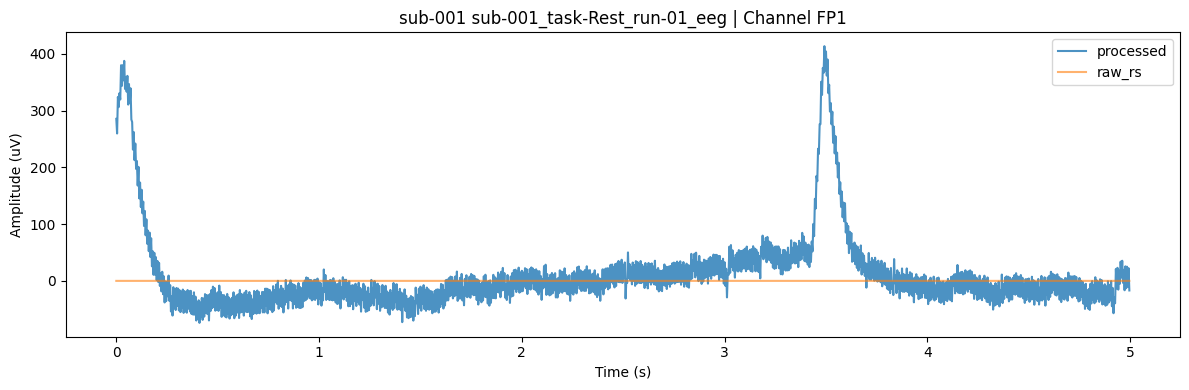

In [18]:
# Plot overlay for a chosen channel
channel_to_plot = intersect[0] if intersect else (proc_chs[0] if proc_chs else None)
print("Plotting channel:", channel_to_plot)
assert channel_to_plot is not None

i = intersect.index(channel_to_plot) if channel_to_plot in intersect else 0
s = 0
win_sec = 5
win = int(win_sec * TARGET_SFREQ)
sl = slice(s, min(s + win, min_len))

t = np.arange(sl.stop - sl.start) / TARGET_SFREQ
plt.figure(figsize=(12, 4))
plt.plot(t, proc_aligned[i, sl], label="processed", alpha=0.8)
plt.plot(t, raw_aligned[i, sl], label="raw_rs", alpha=0.6)
plt.xlabel("Time (s)")
plt.ylabel(f"Amplitude ({proc_units})")
plt.title(f"{SUBJECT_ID} {RUN_STEM} | Channel {channel_to_plot}")
plt.legend()
plt.tight_layout()
plt.show()



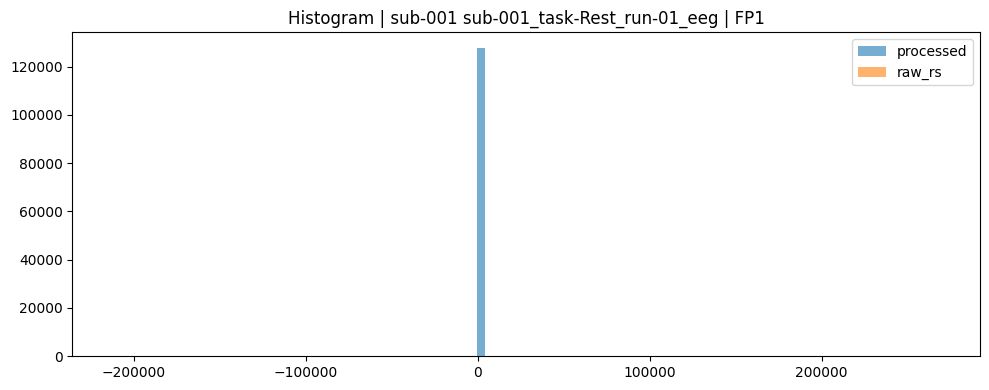

Pearson r=1.0000, p=0


In [19]:
# Distribution comparison and sample-wise correlation for the plotted channel
from scipy.stats import pearsonr

pa = proc_aligned[i, :min_len]
ra = raw_aligned[i, :min_len]

# Histograms
plt.figure(figsize=(10,4))
plt.hist(pa, bins=100, alpha=0.6, label="processed")
plt.hist(ra, bins=100, alpha=0.6, label="raw_rs")
plt.title(f"Histogram | {SUBJECT_ID} {RUN_STEM} | {channel_to_plot}")
plt.legend()
plt.tight_layout()
plt.show()

# Correlation
if pa.std() > 0 and ra.std() > 0:
    r, p = pearsonr(pa, ra)
    print(f"Pearson r={r:.4f}, p={p:.3g}")
else:
    print("Insufficient variance to compute correlation.")

